#### Data loading, preprocessing & splitting

In [1]:
#Importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import floor

In [2]:
#Data loading
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['class'] = iris.target

features = df.iloc[ : , [0,1,2,3]].values
target = df.iloc[ : , 4].values

df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
# Data preprocessing and splitting
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 0)

sc = StandardScaler()
x_train = sc.fit_transform(x_train) #fitting the scaler only based on the training data
x_test = sc.transform(x_test)       #transforming the test_set based on training_set mean&std

#### Softmax Classifier implentation using Pytorch

In [4]:
# Model building - Softmax regression using pytorch
# Note that the model output are logits and not normalized probabilities of Softmax
# the softmax part of the model is used in the criterion of Pytorch CrossEntropyLoss which expects logits as input

class Iris_Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = nn.Linear(4, 3)
        self.bn1 = nn.BatchNorm1d(3)

        # Initialization
        nn.init.kaiming_normal_(self.l1.weight, mode='fan_out', nonlinearity='linear')
        nn.init.zeros_(self.l1.bias)

    def forward(self, x):
        out = self.bn1(self.l1(x))
        return out

In [5]:
#Creating functions that we will use for training

def check_acc(model, x, y):
  input_data = torch.tensor(x , dtype=torch.float32)
  input_labels = torch.tensor(y , dtype=torch.long)

  model.eval()
  with torch.no_grad():
    logits = model(input_data)
    _, predictions = logits.max(1)

    num_correct = (predictions == input_labels).sum()
    num_samples = predictions.size(0)
    acc = num_correct/num_samples

    return acc
  
criterion = nn.CrossEntropyLoss()

def training_loop(model, train_data , train_labels, optimizer, epochs):

  input_data = torch.tensor(train_data , dtype=torch.float32)
  input_labels = torch.tensor(train_labels, dtype=torch.long)

  for e in range(epochs):
      model.train()
      logits = model(input_data)
      loss = criterion(logits, input_labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if e % 25 == 0:
        print(f"Epoch number: {str(e).rjust(3, ' ')} | training loss is: {loss.item():.4f} | test acc is: {100*check_acc(model, x_test, y_test):.2f}%")

In [15]:
#Training the model
model = Iris_Classifier()
optimizer = optim.Adam(model.parameters(), lr= 0.05)

training_loop(model, x_train, y_train, optimizer, epochs= 200)

Epoch number:   0 | training loss is: 0.9361 | test acc is: 63.33%
Epoch number:  25 | training loss is: 0.3737 | test acc is: 83.33%
Epoch number:  50 | training loss is: 0.2789 | test acc is: 96.67%
Epoch number:  75 | training loss is: 0.2236 | test acc is: 100.00%
Epoch number: 100 | training loss is: 0.1865 | test acc is: 96.67%
Epoch number: 125 | training loss is: 0.1614 | test acc is: 96.67%
Epoch number: 150 | training loss is: 0.1438 | test acc is: 96.67%
Epoch number: 175 | training loss is: 0.1303 | test acc is: 100.00%


#### Plotting the data & model classification bounderies using PCA

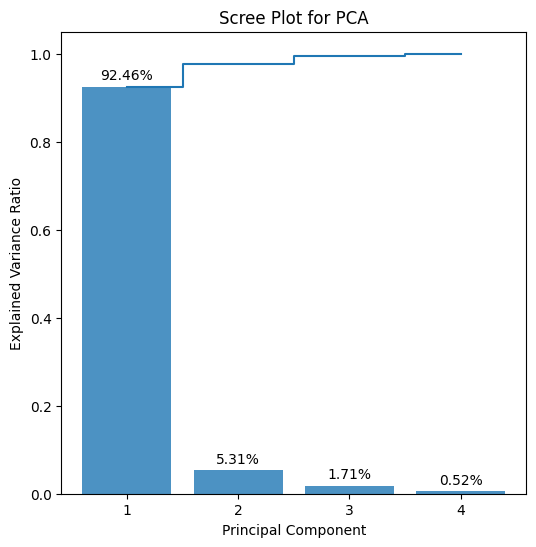


We can account only for PCA's 1 & 2 which together explains 97.77% of the data variance


In [16]:
pca_4d = PCA()
pca_4d.fit(features)
explained_var = pca_4d.explained_variance_ratio_

# Plot scree plot
plt.figure(figsize=(6, 6))
plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.8, align='center')
plt.xticks(range(1, len(explained_var) + 1))
plt.step(range(1, len(explained_var) + 1), np.cumsum(explained_var), where='mid')
plt.title('Scree Plot for PCA')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

# Add values on top of each bar
for i, precentage in enumerate(explained_var):
  plt.text(i + 1, precentage + 0.01, f'{precentage*100:.2f}%', ha='center', va='bottom')

plt.show()

print()
print(f"We can account only for PCA's 1 & 2 which together explains {100*(explained_var[0]+explained_var[1]):.2f}% of the data variance")

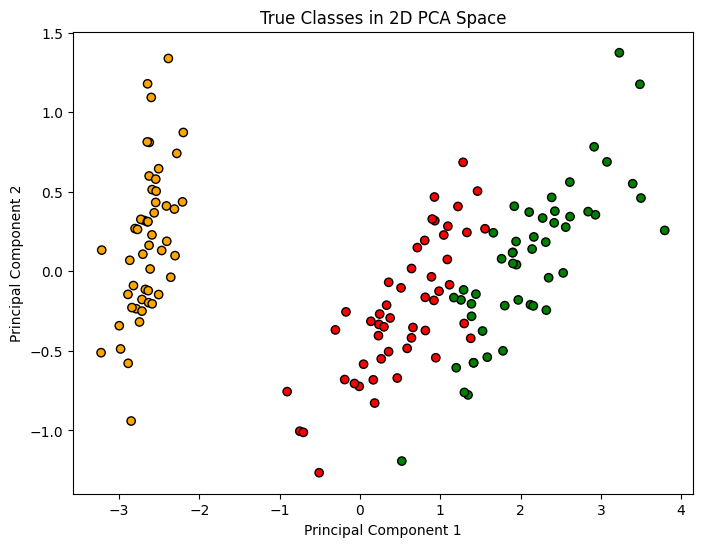

In [17]:
#Plotting the dataset in 2d PCA space
pca = PCA(n_components=2)
X_2d = pca.fit_transform(features)  # Transforming the 4d feature vectors to 2d using PCA algorithm

custom_cmap = ListedColormap(['orange', 'red', 'green'])
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=target, cmap=custom_cmap , edgecolor='k')
plt.title('True Classes in 2D PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

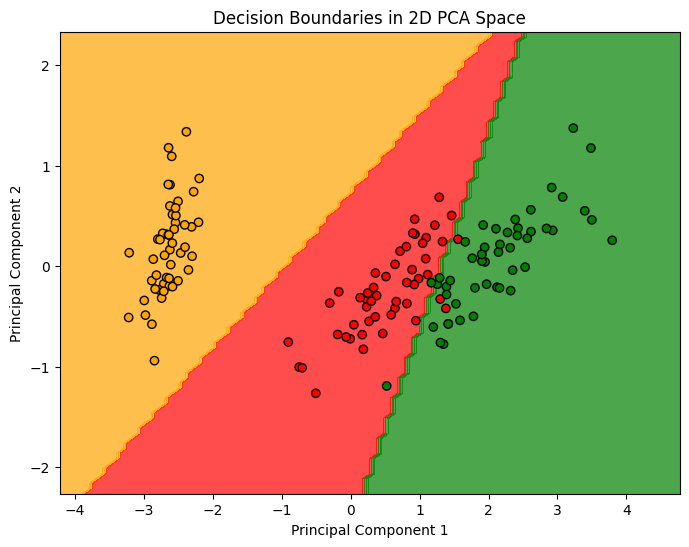

In [18]:
#Plotting model's desicion boundaries
plt.figure(figsize=(8, 6))

# Create a grid of points in the 2D PCA Space that will fill the entire plot area
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.05))

# Concatenate the xx,yy arrays in order to create (x,y) pairs for the entire grid
# Use inverse PCA to return to 4d feature space, scale it in order to match the model
mesh_input = np.c_[xx.ravel(), yy.ravel()]
mesh_input = pca.inverse_transform(mesh_input)
mesh_input = sc.transform(mesh_input)
mesh_input = torch.FloatTensor(mesh_input)

# Create model predictions for each point in the grid
model.eval()
with torch.no_grad():
    Z = model(mesh_input).argmax(dim=1)

Z = Z.numpy()
Z = Z.reshape(xx.shape)

# Plot the grid using contourf plotting to create the desicion boundaries plot
custom_cmap = ListedColormap(['orange', 'red', 'green'])
plt.contourf(xx, yy, Z, cmap=custom_cmap , alpha=0.7)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=target , cmap=custom_cmap , edgecolor='k')

plt.title('Decision Boundaries in 2D PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()